# Config

In [1]:
import numpy as np 
import pickle 
import os 
import torch
import sys
from tqdm import tqdm
sys.path.append("/home/haretis/Experience/DeepLearning/TCN/")
from torch import nn
from torch.autograd import Variable
from time import sleep, time 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler   
from copy import deepcopy
from numpy.random import default_rng 
import argparse
from datetime import datetime
import scipy.signal
from sklearn.decomposition import PCA 
import multiprocessing as mp
rng = default_rng()

## Gather data

In [2]:
def gather_data(folder_path, files):
    data = {}
    for file in files:
        file_name = file.split(".")[0]
        if ".pk" in file:
            with open(folder_path + file, 'rb') as f:
                data[file_name] = pickle.load(f)
        else:
            try:
                data[file_name] = np.loadtxt(folder_path + file)
            except OSError:
                pass 
            except ValueError:
                data[file_name] = None 
    return data

In [3]:
def read_stop_reason(data):
    reasons = ["Time Failure", "Success", "Falling"]
    if "end" in data:
        try:
            end = data['end']
        except KeyError:
            return "Error", 0
        if end is None:
            return "Error", 0
        if len(end) == 0:
            raise NameError("Error empty file")
        i = int(end[1])
        if i>= len(reasons):
            raise NameError("Error not registered reason")
        else:
            return reasons[i], end[0]
    else:
        return "Error", 0
    
def WrongConditionERROR(Exception):
    pass

## Loader //

In [4]:
def loader(path, name, conditions, files=['end']):
    stop_reasons = {}
    xp = path+"/"+name
    res =  {}
    if "config" in files:
        with open(xp+"/"+conditions[0]+"/config.pk", "rb") as f:
            config = pickle.load(f)
        res["config"] = config
        files.remove("config")
    data = {}
    for condition in conditions:
        data[condition] = gather_data(xp+"/"+condition+"/", files)
        if "end.dat" in files:
            stop_reasons[condition] = read_stop_reason(data[condition])
    res["data"] = data
    if "end.dat" in files:
        res["stop_reason"] = stop_reasons
    return name, res

def load_worker(job_queue, res_queue):
    while True:
        job = job_queue.get()
        if job == "Done":
            break
        else:
            f, arg = job
            res_queue.put(f(**arg))
            
def load_master(dicts, jobs, n_jobs, n_processes=50, verbose=1):
    job_queue = mp.Queue()
    res_queue = mp.Queue()
    n_processes = min(n_processes, n_jobs)
    pool = mp.Pool(n_processes, load_worker, (job_queue, res_queue))

    for job in jobs:
        job_queue.put(job)

    for _ in range(n_processes):
        job_queue.put("Done")
    
    todos = []

    for _ in (tqdm(range(n_jobs)) if verbose else range(n_jobs)):
        todos.append(res_queue.get())
    
    for (name, dic) in todos:
        dicts[name] = dic 
    pool.close()
    pool.join()

# Estimate best contact from training data

In [5]:
# contact se3 task (not a contraint)
path1 = "/home/tim/Experiences/Deeplearning/notebooks/data/2022/05/07/14:51:16_9111/data.pk"

In [6]:
with open(path1, "rb") as f:
    data = pickle.load(f)

# save to training/val/test

In [7]:
def read_truth(T):
    copy = np.zeros((21,21))
    for i in range(len(T)):
        for j in range(len(T[i])):
            copy[i, j] = T[i][j] in (["Unfallen"] + [f"Recovered{i}" for i in range(1)])
    return copy

In [8]:
dicts = {}
X = np.linspace(-0.75, 0.75, 21)
Z = np.linspace(0.50, 1.75, 21)
for (key, dic) in data.items():
    if dic["q"] is not None:
        dic["X"] = X
        dic["Z"] = Z
        J = np.zeros(6)
        for c in dic["condition"]:
            J[int(c[-1])-1] = True 
        dic["J"] = J
        dic["map"] = read_truth(dic["truth"])
        dicts[key] = dic
print(len(dicts))

500


## Nothing

In [9]:
nothing = 0
for (key, dic) in data.items():
    if dic["no_reflex_end"] in (["Unfallen"] + [f"Recovered{i}" for i in range(1)]):
        nothing += 1
print(nothing)

65


## D-Reflex data Collection

In [10]:
suc, robust = 0, 0
suc_area, robust_area = [], []
for (key, dic) in data.items():
    suc += np.sum(dic["map"])>1
    suc_area.append(np.sum(dic["map"]))
    T = dic["map"]
    min_pooled = np.zeros(T.shape)
    for z in range(len(T)):
        for x in range(len(T[z])):
            min_pooled[z,x] = np.min(T[max(0, z-1):z+2, max(0, x-1):x+2])
    robust += np.sum(min_pooled) > 0
    robust_area.append(np.sum(min_pooled))

In [11]:
suc/len(data), robust/len(data), np.mean(suc_area), np.mean(robust_area)

(0.114, 0.0, 1.016, 0.0)

## categorie

In [12]:
nothing = {}
for (key, dic) in data.items():
    if dic["no_reflex_end"] in nothing:
        nothing[dic["no_reflex_end"]] += 1
    else:
        nothing[dic["no_reflex_end"]] = 1
total = np.sum([val for (key,val) in nothing.items() if "Recovered" in key])
{key: val/total for (key,val) in nothing.items() if "Recovered" in key}

{'Recovered3': 0.8, 'Recovered1': 0.16, 'Recovered0': 0.04}

In [13]:
D_Reflex = {}
for (key, dic) in data.items():
    for Z in dic["truth"]:
        for x in Z:
            if x is None: 
                x = "Error"
            if x in D_Reflex:
                D_Reflex[x] += 1
            else:
                D_Reflex[x] = 1
total = np.sum([val for (key,val) in D_Reflex.items() if "Recovered" in key])
{key: val/total for (key,val) in D_Reflex.items() if "Recovered" in key}

{'Recovered0': 0.6024590163934426,
 'Recovered3': 0.22540983606557377,
 'Recovered5': 0.1721311475409836}

## Saving

In [30]:
datasets_path = "/home/haretis/Experiences/Deeplearning/notebooks/data/wall_reflex/datasets/"
name = "ALP_v4_2"  # Passive Amputation Locked 
with open(datasets_path + f"{name}_dataset.pk", 'wb') as f:
    pickle.dump(dicts, f)

# Merge additional data

In [31]:
with open(datasets_path + "ALP_v4_1_dataset.pk", 'rb') as f:
    data1 = pickle.load(f)
with open(datasets_path + "ALP_v4_2_dataset.pk", 'rb') as f:
    data2 = pickle.load(f)

In [32]:
len(data1), len(data2)

(1000, 1000)

In [33]:
merged_data = {**data1, **data2}
print(len(merged_data))

2000


In [34]:
with open(datasets_path + "ALP_v4_dataset.pk", 'wb') as f:
    pickle.dump(merged_data, f)

# Plot

In [38]:
with open(path, "rb") as f:
    data = pickle.load(f)

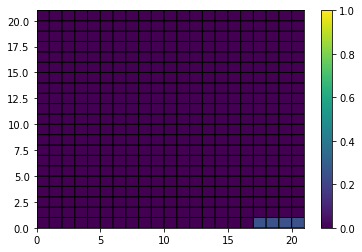

In [50]:
colormap = {"Error": 0., "Falling": 0.25, "Running":0., "Fallen_floor":0.25, "Fallen_wall":0.25, "Unfallen": 1., "Recovered":0.72, "Timeout": 0.}

dic = list(data.values())[8]

cmap = np.zeros((21, 21))
for i in range(21):
    for j in range(21):
        cmap[i,j] = colormap[dic["truth"][i][j]]
lines = plt.pcolor(cmap, cmap="viridis", edgecolors='k', vmin=0, vmax=1, linewidths=1)
plt.colorbar(lines)

# Avoidable / Robustly avoidable

In [67]:
with open(datasets_path + "ALP_v2_dataset.pk", 'rb') as f:
    data2 = pickle.load(f)

In [68]:
with open(datasets_path + "ALP_v1_dataset.pk", 'rb') as f:
    data1 = pickle.load(f)

In [73]:
def compute_avoidability_rate(data):
    robustly_avoidable, avoidable = 0, 0
    for dic in data.values():
        T = dic["map"] if "map" in dic else dic["truth"]
        min_pooled = np.zeros(T.shape)
        for z in range(len(T)):
            for x in range(len(T[z])):
                min_pooled[z,x] = np.min(T[max(0, z-1):z+2, max(0, x-1):x+2])
        if np.sum(min_pooled) > 0:
            robustly_avoidable += 1
        if np.sum(T) > 0:
            avoidable += 1 
    return robustly_avoidable, avoidable

In [76]:
ra2, a2 = compute_avoidability_rate(data2)

In [77]:
ra1, a1 = compute_avoidability_rate(data1)

In [86]:
for a, ra in [(a1, ra1), (a2, ra2)]:
    print(f"{a/2000*100:2.1f}% avoidable of which {ra/a*100:2.1f}% are robustly avoidable (= {ra/2000*100:2.1f}% robustly avoidable in total)") 

63.7% avoidable of which 52.4% are robustly avoidable (= 33.4% robustly avoidable in total)
70.8% avoidable of which 57.4% are robustly avoidable (= 40.6% robustly avoidable in total)
